In [1]:
import pickle

# Third-party
import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from pyia import GaiaData

import pystan

In [2]:
gd1 = GaiaData('/Users/adrian/projects/gd1-dr2/data/gd1-better-selection.fits')

In [3]:
phi1 = gd1.phi1.value
phi2 = gd1.phi2.value

To place the nodes, we use the ridgeline:

In [4]:
ridge = Table.read('../output/gd1_ridgeline.csv')

In [5]:
c = coord.SkyCoord(ridge['ra']*u.deg, ridge['dec']*u.deg).transform_to(gc.GD1)
phi_poly = np.poly1d(np.polyfit(c.phi1.wrap_at(180*u.deg).degree,
                                c.phi2.degree, 
                                deg=5))

phi1 spacing: 1.428571428571452


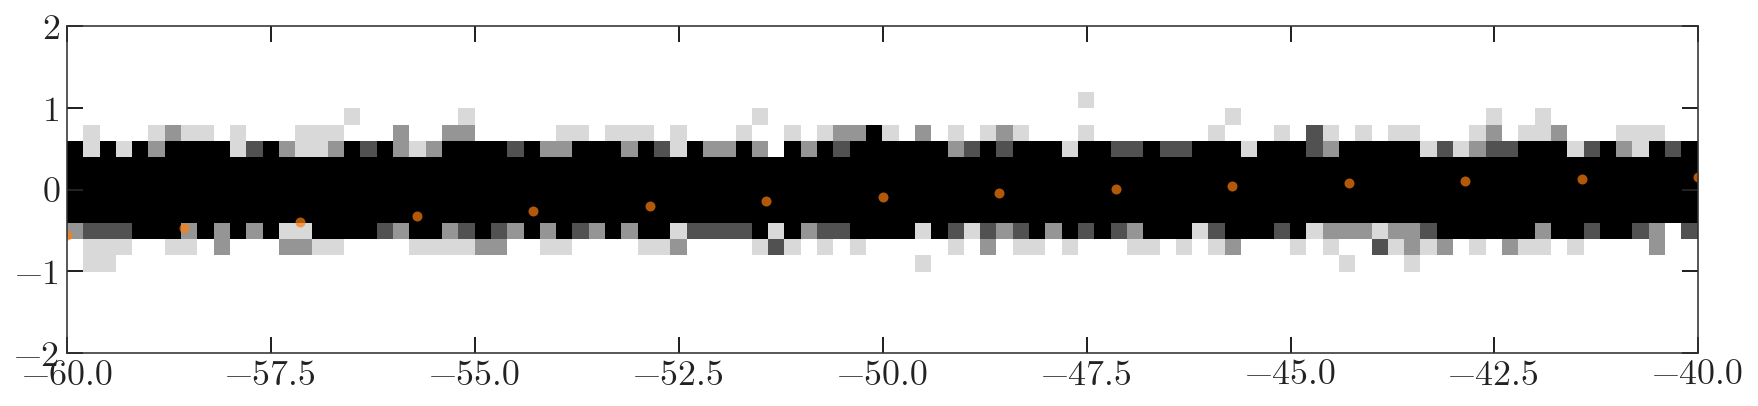

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

# H, xe, ye = np.histogram2d(phi1, phi2, 
#                            bins=(np.arange(-100, 20+1e-3, 0.5),
#                                  np.arange(-10, 5+1e-3, 0.5)))

# TODO: start with a patch
# H, xe, ye = np.histogram2d(phi1, phi2, 
#                            bins=(np.arange(-60, -40+1e-3, 0.5),
#                                  np.arange(-2, 2+1e-3, 0.5)))

# TODO: start with fake data:
ntest = 8000
_phi1 = np.random.uniform(-60, -40, size=ntest)
_phi2 = np.random.normal(0, 0.25, size=ntest)
H, xe, ye = np.histogram2d(_phi1, _phi2, 
                           bins=(np.arange(-60, -40+1e-3, 0.2),
                                 np.arange(-2, 2+1e-3, 0.2)))
xe_c = 0.5 * (xe[:-1] + xe[1:])
ye_c = 0.5 * (ye[:-1] + ye[1:])

ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmin=0, vmax=4)

# phi1_nodes = np.linspace(-100, 20, 100)
phi1_nodes = np.linspace(xe.min(), xe.max(), 15)
print('phi1 spacing: {}'.format(phi1_nodes[1]-phi1_nodes[0]))
phi2_nodes = phi_poly(phi1_nodes)
ax.plot(phi1_nodes, phi2_nodes, 
        marker='o', alpha=0.7, 
        ls='none', color='tab:orange')

ax.set_aspect('equal')

In [7]:
xx, yy = np.stack(list(map(np.ravel, np.meshgrid(xe_c, ye_c))))

In [8]:
# data_dict = {}
# data_dict['n_pix'] = H.size
# data_dict['hh'] = H.ravel().astype(np.int32)
# data_dict['x'] = xx
# data_dict['y'] = yy

# data_dict['n_int_nodes'] = len(phi1_nodes)
# data_dict['int_nodes'] = phi1_nodes

# data_dict['n_fi2_nodes'] = len(phi1_nodes)
# data_dict['fi2_nodes'] = phi1_nodes

# data_dict['n_width_nodes'] = len(phi1_nodes)
# data_dict['width_nodes'] = phi1_nodes

In [9]:
# nchains = 1

# inits = []
# for i in range(nchains):
#     init_dict = {}
#     init_dict['log_ints'] = np.log(np.random.normal(10, 1) * np.ones(len(phi1_nodes)))
#     init_dict['fi2s'] = np.random.normal(0, 0.01, size=len(phi1_nodes))
#     init_dict['log_widths'] = np.log(np.random.normal(0.25, 0.05) * np.ones(len(phi1_nodes)))
#     inits.append(init_dict)

# nchains = 1
# init_dict = {}
# init_dict['log_ints'] = np.log(4 * np.ones(len(phi1_nodes)))
# init_dict['fi2s'] = np.zeros(len(phi1_nodes))
# init_dict['log_widths'] = np.log(0.25 * np.ones(len(phi1_nodes)))
# inits = [init_dict]

In [10]:
data_dict = {}
data_dict['n_pix'] = H.size
data_dict['hh'] = H.ravel().astype(np.int32)
data_dict['x'] = xx
data_dict['y'] = yy

data_dict['n_nodes'] = len(phi1_nodes)
data_dict['phi1_nodes'] = phi1_nodes
data_dict['phi2_nodes_init'] = phi2_nodes
data_dict['h_nodes'] = np.full_like(phi1_nodes, 2.)

In [11]:
nchains = 1
init_dict = {}
init_dict['d_phi2_nodes'] = np.zeros(data_dict['n_nodes'])
init_dict['log_w_nodes'] = np.full(data_dict['n_nodes'], np.log(0.25))
init_dict['log_N_nodes'] = np.full(data_dict['n_nodes'], np.log(10))
inits = [init_dict]

In [12]:
# sm = pystan.StanModel('../stan/binned_model_koposov.stan')
# sm = pystan.StanModel('../stan/binned_model_simple.stan')
sm = pystan.StanModel('../stan/binned_model_apw.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_031978fd0a84d678731f1dc68b721358 NOW.


In [ ]:
fit = sm.sampling(data=data_dict, algorithm='NUTS', 
                  init=inits, 
                  iter=100, chains=nchains, n_jobs=1)

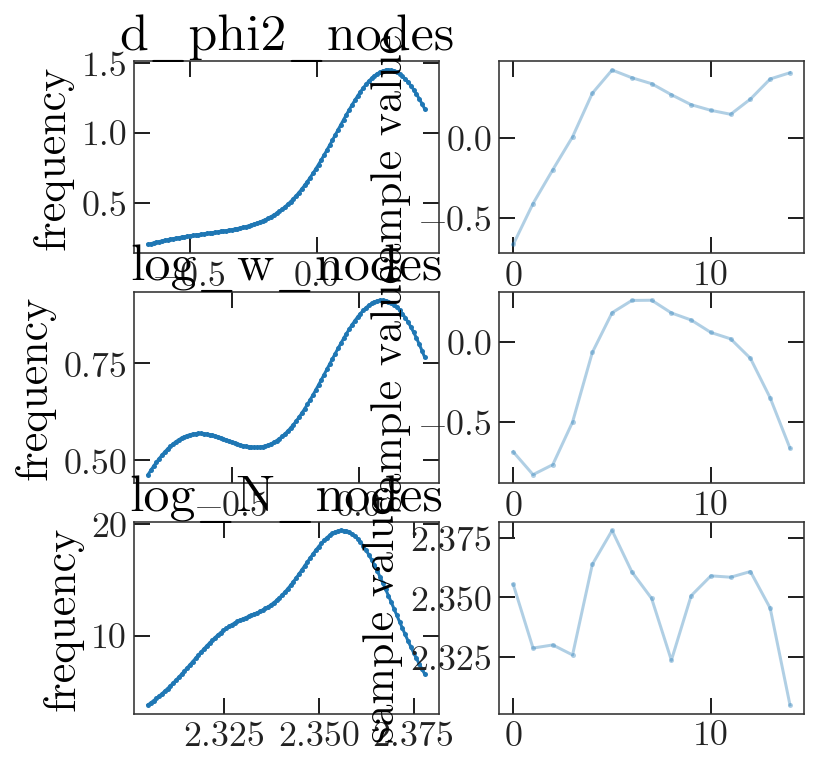

In [25]:
_ = fit.plot(pars=['d_phi2_nodes', 'log_w_nodes', 'log_N_nodes'])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmin=0, vmax=4)

ax.plot(phi1_nodes, fit['phi2_nodes'][-1], 
        marker='o', color='tab:orange')

# ax.plot(phi1_nodes, phi2_nodes, 
#         marker='o', alpha=0.7, 
#         ls='none', color='tab:orange')

ax.set_aspect('equal')

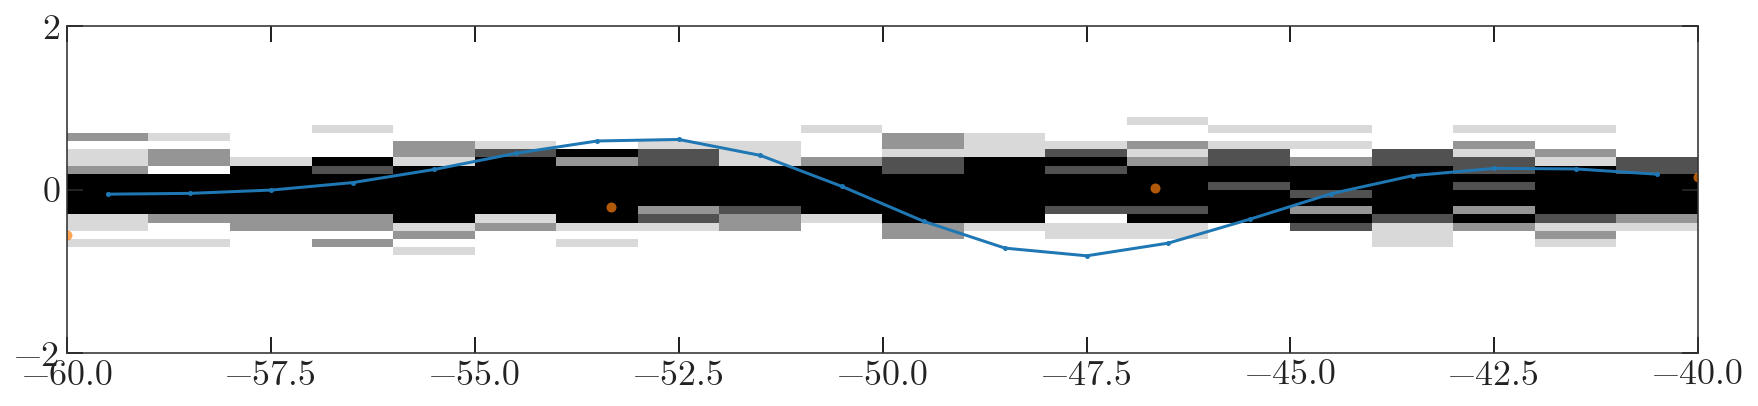

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmin=0, vmax=4)

ax.plot(xe_c, fit['fi2_val'][-1].reshape(H.T.shape)[0])

# phi1_nodes = np.linspace(-100, 20, 100)
phi1_nodes = np.linspace(-60, -40, 4)
phi2_nodes = phi_poly(phi1_nodes)
ax.plot(phi1_nodes, phi2_nodes, 
        marker='o', alpha=0.7, 
        ls='none', color='tab:orange')

ax.set_aspect('equal')

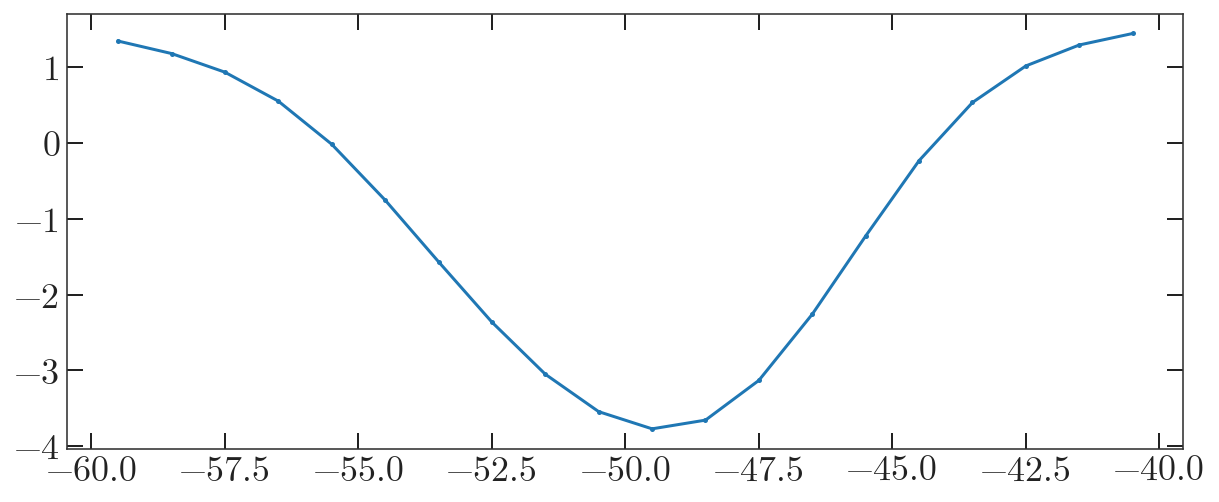

In [141]:
plt.figure(figsize=(10, 4))
plt.plot(xe_c, fit['logint_val'][-1].reshape(H.T.shape)[0])

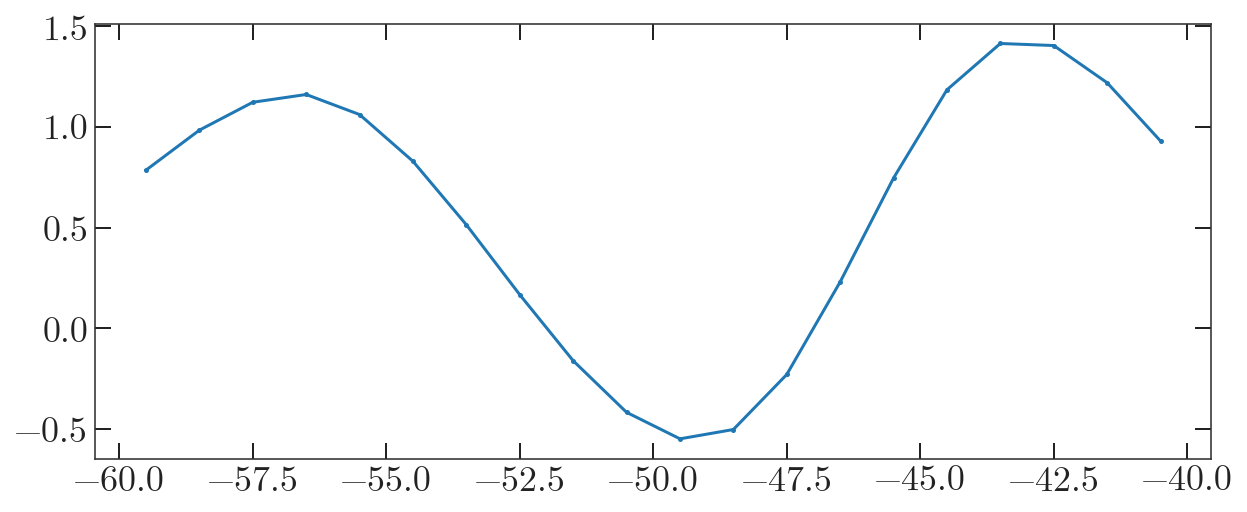

In [142]:
plt.figure(figsize=(10, 4))
plt.plot(xe_c, fit['logwidth_val'][-1].reshape(H.T.shape)[0])

In [ ]:
# with suppress_stdout_stderr():
#     fit = sm.sampling(data=data_dict, algorithm='HMC', iter=8192, init=init_dict, 
#                       chains=n_chains, n_jobs=1)